In [1]:
import numpy as np
from scipy import fft
from matplotlib import pyplot as plt
import scipy.io

In [2]:
rootfolder = '.'

# Generating 1-D DCT basis
Generate the DCT basis according to the following formula (DCT type II) the $k$-th atom of the DCT basis in dimension $M$ is defined as:
$$DCT_k(n) = c_k \cos(k \pi \frac{2n + 1}{2M}) \quad n, k = 0, \dots, M-1$$
where $c_0 = \sqrt{\frac{1}{M}}$ and $c_k = \sqrt{\frac{2}{M}}$ for $k \neq 0$.

For each $k = 0, \dots, M-1$, just sample each function $\cos(k\pi\frac{2n+1}{2M})$ at $n = 0, \dots, M-1$, obtain a vector. Ignore the normalization coefficient. Divide each vector by its $l_2$ norm.

In [ ]:
M = 128 # signal dimension
N = M # nr of atoms in the basis (this will be different when using redundant set of generators)

D = np.zeros((M, N)) # matrix containing the DCT basis (a DCT function in each column)
DCT = np.zeros((M, N)) # matrix containing the standard basis (a kronecker delta in each column)

n = np.arange(M)
for k in range(1, M):
    # take the formula from slides and remember to normalize. Each atom goes in a column of DCT matrix
    DCT[:, k] = np.cos(k * np.pi * (2 * n + 1) / (2 * M))
    DCT[:, k] /= np.linalg.norm(DCT[:, k])

Display an atom of the dct basis

Text(0.5, 1.0, 'element: 35 from the DCT basis')

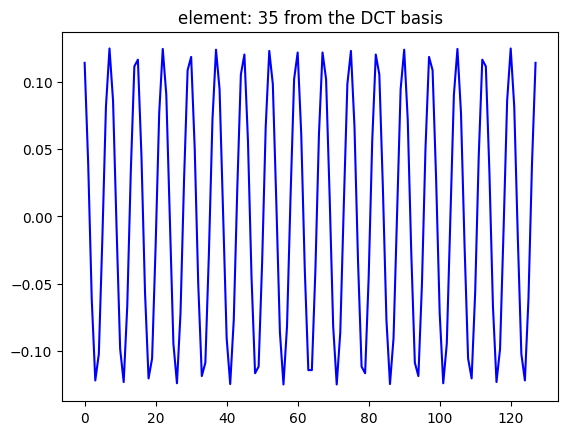

In [5]:
k = 34
plt.figure()
plt.plot(DCT[:, k], 'b')
plt.title(f'element: {k+1} from the DCT basis')

Check orthogonality

In [6]:
is_DCT_orth = np.allclose(np.dot(DCT.T, DCT), np.eye(M))
print(f'DCT dictionary is orthogonal: {is_DCT_orth}')

DCT dictionary is orthogonal: False


Display the basis in the matrix

Text(0.5, 1.0, 'DCT basis, atoms in the column')

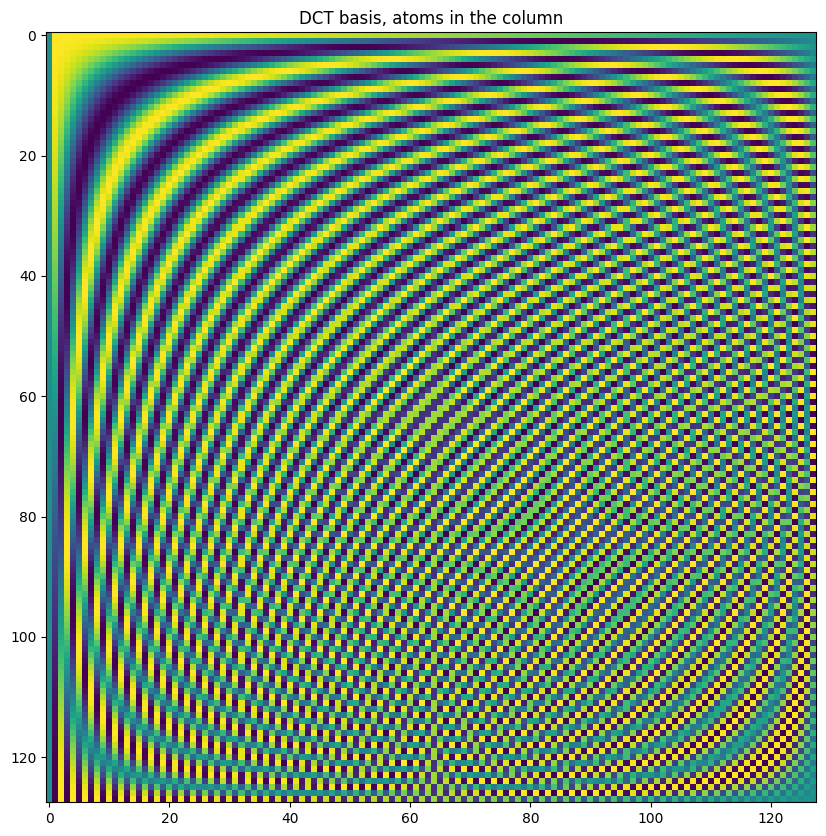

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')

Generate 1D DCT basis using the function idct
---------------------------------------------
idct is the inverse dct transform stack this in the matrix D

In [8]:
for k in range(M):
    # define the atom
    a = np.zeros(M)
    a[k] = 1
    D[:, k] = fft.idct(a, norm='ortho')

Display the basis in the matrix

Text(0.5, 1.0, 'DCT basis, atoms in the column')

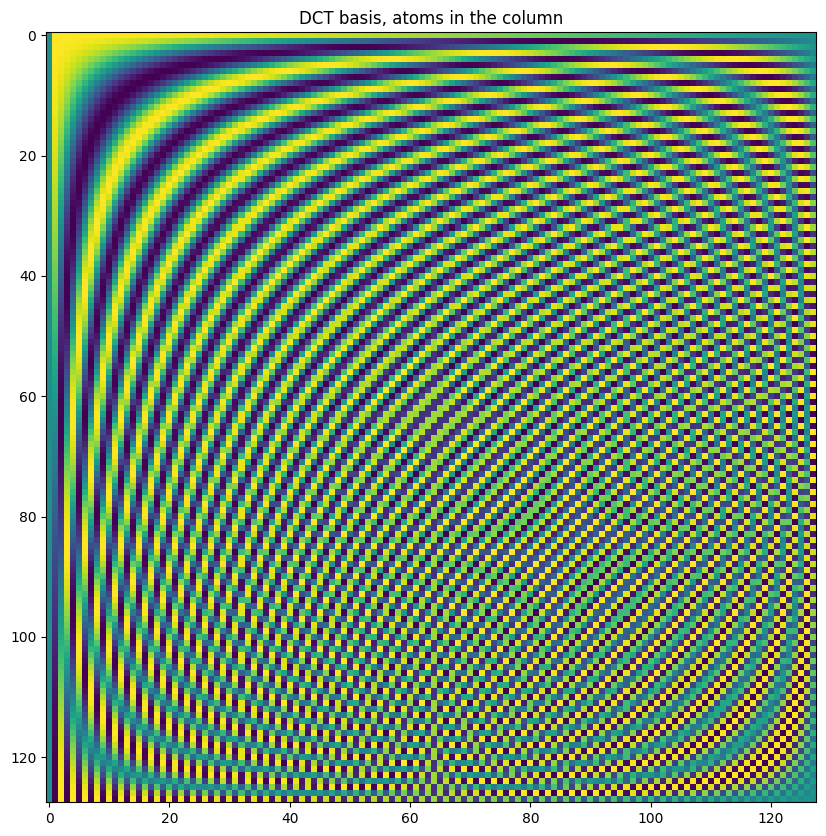

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')

Check that D and DCT defined above coincide

In [10]:
is_DCT_equal_D = np.allclose(D, DCT)
print(f'D and DCT are equal: {is_DCT_equal_D}')

D and DCT are equal: False


Analysis: compute the representation of an input ECG signal
-----------------------------------------------------------
Load few ECG signals to be processed

In [11]:
temp = scipy.io.loadmat(f'{rootfolder}/data/croppedECG.mat')
nBeats = 10
S = temp['S'][:, :nBeats]
X = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D

Compute the representation coefficients

In [12]:
for i in range(nBeats):
    X[:, i] = DCT.T @ S[:, i]

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

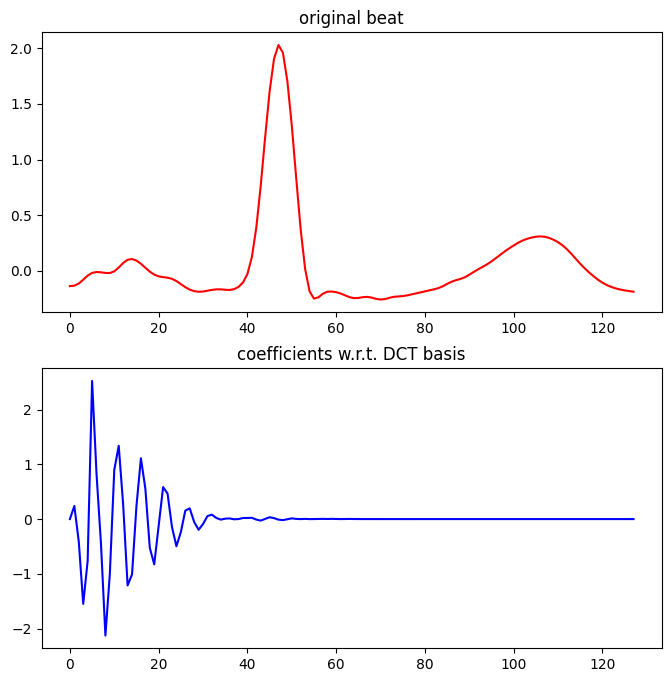

In [13]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(X[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')

Synthesis: reconstruct all the ECG signals from their representations
---------------------------------------------------------------------
Reconstruct the two signals (express them w.r.t. the standard basis)

In [14]:
S_hat_D = DCT @ X

Check if there is perfect reconstruction.

It is trivial because $\hat S_D = DD^TS$ and $DD^T = I_M$  since $D$ is orthonormal (the same applies to $C$)

In [15]:
is_reconstruction_perfect = np.allclose(S, S_hat_D)
print(f'The reconstruction is perfect: {is_reconstruction_perfect}')

The reconstruction is perfect: False


Add noise to ECG data and inspect the representations
-----------------------------------------------------


In [16]:
sigma_noise = 0.1
S0 = S.copy()
S = S0 + sigma_noise * np.random.normal(size=S0.shape)

X = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D

Compute the representation coefficients

In [17]:
for i in range(nBeats):
    X[:, i] = DCT.T @ S[:, i]

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

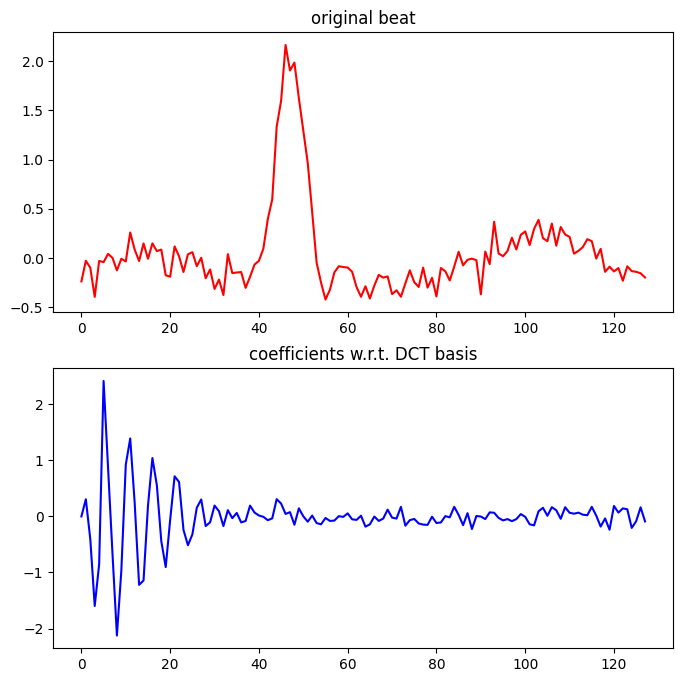

In [18]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'r')
ax1.set_title('original beat')
ax2.plot(X[:, i], 'b')
ax2.set_title('coefficients w.r.t. DCT basis')

Hard Thresholding
-----------------
Noise affects all the coefficients of our transformation

Keep only $L$ coefficients having largest magnitude

In [19]:
X_HT = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D
S_hat = np.zeros((M, nBeats))
L = 21 # sparsity level (try different values)

for i in range(nBeats):
    origSignal = S[:, i]  # original signal (i-th column from S matrix)
    noisySignal = origSignal +  sigma_noise * np.random.normal(size=origSignal.shape)  # adding noise to signal

    # transform each signal separately (analysis)
    x = D.T @ noisySignal  # project onto dictionary/basis

    # keep only the L largest coefficients (absolute value)
    x_HT_i = np.zeros_like(x)
    indices = np.argsort(np.abs(x))[-L:]  # indices of L largest coefficients
    x_HT_i[indices] = x[indices]
    x_HT[:, i] = x_HT_i

    # invert the transformation
    s_hat = D @ x_HT_i  # synthesis step (reconstruction)

    S_hat[:, i] = s_hat

NameError: name 'x_HT' is not defined

Display a signal

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'r')
ax1.plot(S0[:, i], 'b--')
ax1.plot(S_hat[:, i], 'k')
ax1.legend(['noisy', 'original', 'hard-thresholded'])
ax1.set_title('original beat')

# coefficients of the noisy signal
ax2.plot(np.matmul(D.T, S[:, i]), 'r.')
# coefficients of the noise free signal
ax2.plot(np.matmul(D.T, S0[:, i]), 'b--')
ax2.stem(np.arange(M), X_HT[:, i], 'k')
ax2.set_title('DCT coefficients')

Compression
-----------
Try to compress a heartbeat using different value of $L$ and plot the mean squared error corresponding to each $L$

In [ ]:
x_HT = np.zeros((M)) # initialize the matrix of representations of S w.r.t. D
s_hat = np.zeros((M))

L_values = np.arange(1, M+1)
MSE_values = np.zeros(M)

origSignal = S[:, 0]

for L in L_values:
    # transform each signal separately (analysis)
    x = #

    # keep only the L largest coefficients (absolute value)
    #[...]
    x_HT[:, i] = #

    # invert the transformation
    s_hat = #

    mse = #

    MSE_values[L-1] = mse

plt.figure(figsize=(10,6))
plt.plot(L_values, MSE_values, '-o')
plt.xlabel('L')
plt.ylabel('MSE')
plt.title('Compression performance')
plt.grid()